# Kaggle - Understanding the Amazon from Space

## Data loading

In [1]:
import os
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import cv2
from skimage import io
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("../data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
#labels_df.head()

In [4]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
#print(label_list)
            
# Preprocess labels
label_map = {l: i for i, l in enumerate(label_list)}

In [5]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [6]:
def sample_images(tags, n=None, complement=False):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == (not complement)
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [7]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            #print('Found image {}'.format(path))
            return io.imread(path)
    # If this line reached, image not found
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

## Data inspection

In [8]:
# Histogram of label instances
#labels_df[label_list].sum().sort_values().plot.bar()

In [9]:
def cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

selected_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy', 'primary', 'agriculture', 'water', 'road']
#cooccurence_matrix(selected_labels)

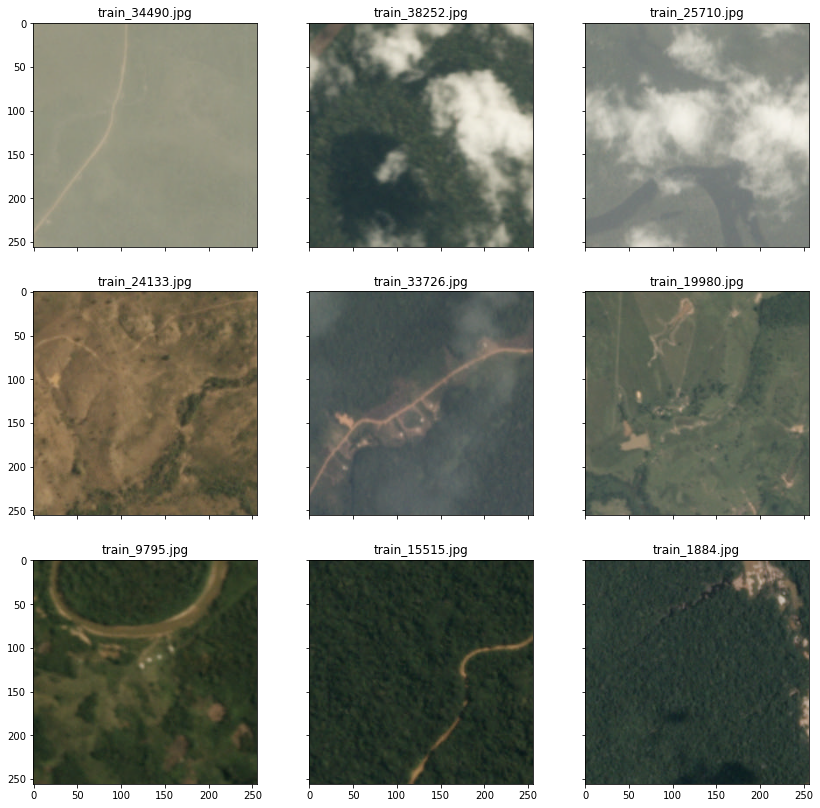

In [10]:
sampled_images = sample_images(['water'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]        
        
        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

## Labeling functions - helper functions and preprocessing



In [11]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def evaluate_LF(LF, df, tag, n=1000, full_dataset = False, print_evaluation=True):
    #print(namestr(LF, globals()))
    
    if full_dataset:
        n = df.shape[0]
    
    # Sample images with the passed tag
    sampled_images = df[:].sample(n)

    # Evaluate
    tp, fp, tn, fn = 0, 0, 0, 0
    abst = 0
    for index, row in sampled_images.iterrows():
        pred = LF(row)
        if pred == 1: 
            if row[tag] == 1:
                tp += 1
            else:
                fp += 1
        elif pred == 0:
            if row[tag] == 0:
                tn += 1
            else:
                fn += 1
        else:
            abst += 1  

    # Calculate the accuracy of LF
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    coverage = (n - abst) / n
    
    if print_evaluation:
        print('TP: ', tp)
        print('FP: ', fp)
        print('TN: ', tn)
        print('FN: ', fn)
        print('abstain: ', abst)
        print('accuracy', accuracy)
        print('coverage', coverage)
        
    return

In [12]:
# Splits of the original Kaggle dataset for training, validation and testing
SPLIT_TRAIN = 10000
SPLIT_VALIDATE = 12000

Load BigEarthNet remote sensing pre-trained model (Sentinel-2 data, 590k size)
https://arxiv.org/pdf/1911.06721.pdf

Model was subsequently trained on 12k (10k training, 2k validation) labeled jpg images from the Kaggle training dataset (see remote_sensing.py)

In [13]:
import tensorflow as tf
import tensorflow_hub as hub

batch_size = 128
heigth = 224
width = 224
no_channels = 3

# Create model and load model weights
module = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1")
model = tf.keras.Sequential([module,
                             tf.keras.layers.Dense(17, activation="sigmoid")])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape = (batch_size, heigth, width, no_channels))
model.load_weights('../models/trained/bigearthnet-resnet_model_v05_weights.hdf5')
model.summary()


/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23633899  
_________________________________________________________________
dense (Dense)                multiple                  34833     
Total params: 23,668,732
Trainable params: 34,833
Non-trainable params: 23,633,899
_________________________________________________________________


Predict labels with the pre-trained model and set thresholds for abstaining

In [14]:
# Prepare array of images to predict classes with model
#x_train = []
y_train = []


for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
#    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
#    x_train.append(cv2.resize(img, (224, 224)))
    y_train.append(targets)    
    
# Normalize images into the interval [0,1]
y_train = np.array(y_train, np.uint8)
#x_train = np.array(x_train, np.float16) / 255.

#x_train, x_valid, x_test = (x_train[:SPLIT_TRAIN], x_train[SPLIT_TRAIN:SPLIT_VALIDATE], x_train[SPLIT_VALIDATE:])
y_train, y_valid, y_test = (y_train[:SPLIT_TRAIN], y_train[SPLIT_TRAIN:SPLIT_VALIDATE], y_train[SPLIT_VALIDATE:])


100%|██████████| 40479/40479 [00:00<00:00, 224284.05it/s]


In [15]:
# Predict
#p_train = model.predict(x_train, batch_size=128)
#p_valid = model.predict(x_valid, batch_size=128)
#p_test = model.predict(x_test, batch_size=128)

# Directly load predicted features for the complete dataset (computed on cluster)
p_train = np.genfromtxt('../models/predictions/features_bigearth_v06_p_train.csv', delimiter=',')
p_valid = np.genfromtxt('../models/predictions/features_bigearth_v06_p_valid.csv', delimiter=',')
p_test = np.genfromtxt('../models/predictions/features_bigearth_v06_p_test.csv', delimiter=',')

assert len(p_test)== len(y_test)

print(p_test[:3,:])
print(y_test[:3,:])

[[4.88168597e-01 9.80332732e-01 6.12525344e-02 3.62358421e-01
  4.12835777e-02 9.16162133e-03 3.38178575e-02 1.78963244e-02
  2.44247913e-03 9.82058048e-03 1.28939927e-01 1.61060691e-03
  1.01838410e-02 1.17114186e-03 7.61008263e-03 2.70891190e-03
  3.03727388e-03]
 [2.47734785e-03 9.92867112e-01 7.00310111e-01 8.13476682e-01
  2.47898936e-01 5.92001379e-02 1.32741868e-01 1.49581850e-01
  5.58599830e-03 5.37276268e-04 1.41373038e-01 3.11499834e-03
  9.06886160e-02 2.08328366e-02 1.02986693e-02 4.39661741e-03
  4.10342216e-03]
 [8.55540037e-01 8.89050007e-01 1.54513180e-01 4.68403995e-02
  1.61963075e-01 1.69787705e-02 5.77568710e-02 2.91395783e-02
  1.95530057e-03 1.02427930e-01 5.63713312e-02 2.09730864e-03
  1.07714236e-02 1.01163983e-03 1.61665678e-03 1.01438165e-03
  1.25804543e-03]]
[[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [155]:
# Set thresholds for voting positive and abstaining

import scipy.stats

def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


resnet_thresholds = np.zeros((len(label_list),2))

# Calculate positive and abstain thresholds based on mean and std. deviation of predictions of train samples
for i in range(len(label_list)):
    arr = np.multiply(p_valid[:, i], y_valid[:, i])
    non_zero_arr = arr[np.where(arr!=0)]
    _, resnet_thresholds[i,0], _ = mean_confidence_interval(non_zero_arr)
    
    arr = np.multiply(p_valid[:, i], np.logical_not(y_valid[:, i]))
    non_zero_arr = arr[np.where(arr!=0)]
    _, _, resnet_thresholds[i,1] = np.minimum(mean_confidence_interval(non_zero_arr), resnet_thresholds[i,0])

print(resnet_thresholds[:,:])

[[ 4.34697135e-01  4.60413384e-02]
 [ 9.77005450e-01  5.27294026e-01]
 [ 6.45682334e-01  1.47399456e-01]
 [ 8.69168979e-01  2.65808712e-01]
 [ 5.42492332e-01  1.15322297e-01]
 [ 3.66905611e-01  5.96805918e-02]
 [ 5.89549578e-01  8.88502919e-02]
 [ 2.30557992e-01  7.09633402e-02]
 [ 2.47694539e-03  2.47694539e-03]
 [ 5.58929689e-01  1.20882850e-02]
 [ 5.91473136e-01  1.13720894e-01]
 [-1.19595617e-02 -1.19595617e-02]
 [ 8.03865766e-02  2.11557546e-02]
 [ 1.61002552e-01  5.49323834e-03]
 [ 1.96210605e-02  9.10638614e-03]
 [ 1.20344979e-02  7.95532241e-03]
 [ 4.81597143e-04  4.81597143e-04]]


Compute UMAP embedding for ResNet features to "draw" LFs in a plane as opposed to setting thresholds based on mean and std_dev

In [65]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_neighbors=60,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)

#TBD: Is there a way to leverage the labels for p_train and p_valid as semi-supervised classification,
# given it is a multi-label problem? UMAP assumes single label classification (obviously)

#reducer.fit(np.concatenate((p_train,p_valid,p_test), axis = 0))
reducer.fit(p_test)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
     n_neighbors=60, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [66]:
embedding_UMAP = reducer.transform(p_test) 

In [232]:
# Manually set polygons within UMAP embedding to cluster/label data for following labels:
# 0 - haze
# 1 - primary
# 2 - agriculture
# 3 - clear
# 4 - water
# 5 - habitation
# 6 - road
# 9 - cloudy
# 10 - partly_cloudy

# TBD: more precise polygons/bounding boxes including abstaining regions

from shapely.geometry import Point, Polygon

resnet_coords = [[] for i in range(17)]
resnet_coords[0] = [(6.2, 5), (6.2, 8), (9.0, 8), (9.0, 5)]
resnet_coords[1] = [(-6, -6), (-6, 7.5), (14, 7.5), (14, -6)]
resnet_coords[2] = [(5.5, -6), (5.5, 2), (11.5, 2), (11.5, -6)]
resnet_coords[3] = [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)]
resnet_coords[4] = [(10.5, -4.5), (10.5, 2.5), (14.5, 2.5), (14.5, -4.5)]
resnet_coords[5] = [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)]
resnet_coords[6] = [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)]
resnet_coords[9] = [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)]
resnet_coords[10] = [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)]

print(resnet_coords)

[[(6.2, 5), (6.2, 8), (9.0, 8), (9.0, 5)], [(-6, -6), (-6, 7.5), (14, 7.5), (14, -6)], [(5.5, -6), (5.5, 2), (11.5, 2), (11.5, -6)], [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)], [(10.5, -4.5), (10.5, 2.5), (14.5, 2.5), (14.5, -4.5)], [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)], [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)], [], [], [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)], [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)], [], [], [], [], [], []]


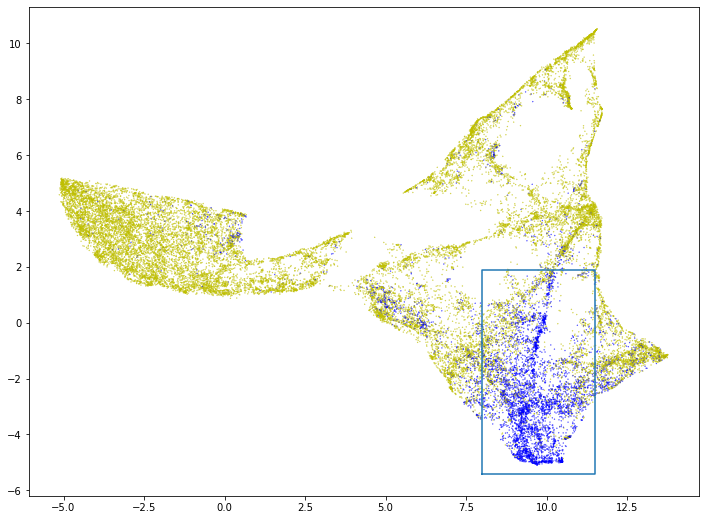

In [234]:
# Display manual clustering of the UMAP embedding

label_id = 6

coords = resnet_coords[label_id]
poly = Polygon(coords)

color = []
for i in range(len(y_test)):
    if y_test[i,label_id] == 1:
        color.append('b') #
    else:
        color.append('y') #other

plt.figure(figsize=(12,9))
plt.scatter(embedding_UMAP[:, 0], embedding_UMAP[:, 1], c=color, s=0.1, cmap='Scatter')
plt.plot(*poly.exterior.xy)

Split df with labels for training, validation and testing datasets

In [20]:
labels_df_train = labels_df.iloc[:SPLIT_TRAIN]
labels_df_valid = labels_df.iloc[SPLIT_TRAIN:SPLIT_VALIDATE]
labels_df_test = labels_df.iloc[SPLIT_VALIDATE:]

## Labelling functions for selected classes

Classes considered: haze, primary, agriculture, clear, water, road, cloudy, partly_cloudy, habitation

In [98]:
# Define label mappings for Snorkle voting for convenience
NEGATIVE = 0
POSITIVE = 1
ABSTAIN = -1

In [152]:
# Define category mappings within labels_df for convenience
HAZE_MAP = 0
PRIMARY_MAP = 1
AGRICULTURE_MAP = 2
CLEAR_MAP = 3
WATER_MAP = 4
HABITATION_MAP = 5
ROAD_MAP = 6
CLOUDY_MAP = 9
PARTLY_CLOUDY_MAP = 10 

In [160]:
def habitation_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i, HABITATION_MAP] > resnet_thresholds[HABITATION_MAP,0]:
        return POSITIVE
    elif p_test[i, HABITATION_MAP] > resnet_thresholds[HABITATION_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [161]:
evaluate_LF(habitation_ResNet_1, labels_df_test, 'habitation', full_dataset = False)

TP:  36
FP:  26
TN:  733
FN:  11
abstain:  194
accuracy 0.9540942928039702
coverage 0.806


In [245]:
def habitation_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[HABITATION_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [246]:
evaluate_LF(habitation_ResNet_2, labels_df_test, 'habitation', full_dataset = False)

TP:  31
FP:  24
TN:  898
FN:  47
abstain:  0
accuracy 0.929
coverage 1.0


In [43]:
def cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [44]:
evaluate_LF(cloudy_ResNet_1, labels_df_test, 'cloudy', full_dataset = False)

TP:  25
FP:  7
TN:  864
FN:  0
abstain:  104
accuracy 0.9921875
coverage 0.896


In [47]:
def haze_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,HAZE_MAP] > resnet_thresholds[HAZE_MAP,0]:
        return POSITIVE
    elif p_test[i, HAZE_MAP] > resnet_thresholds[HAZE_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [48]:
evaluate_LF(haze_ResNet_1, labels_df_test, 'haze', full_dataset = False)

TP:  37
FP:  19
TN:  792
FN:  1
abstain:  151
accuracy 0.9764428739693758
coverage 0.849


In [148]:
def haze_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[HAZE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [149]:
evaluate_LF(haze_ResNet_2, labels_df_test, 'haze', full_dataset = False)

TP:  32
FP:  8
TN:  932
FN:  28
abstain:  0
accuracy 0.964
coverage 1.0


In [49]:
def primary_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,PRIMARY_MAP] > resnet_thresholds[PRIMARY_MAP,0]:
        return POSITIVE
    elif p_test[i, PRIMARY_MAP] > resnet_thresholds[PRIMARY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [50]:
evaluate_LF(primary_ResNet_1, labels_df_test, 'primary', full_dataset = False)

TP:  788
FP:  2
TN:  39
FN:  10
abstain:  161
accuracy 0.9856972586412396
coverage 0.839


In [235]:
def primary_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[PRIMARY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [236]:
evaluate_LF(primary_ResNet_2, labels_df_test, 'primary', full_dataset = False)

TP:  912
FP:  32
TN:  51
FN:  5
abstain:  0
accuracy 0.963
coverage 1.0


In [51]:
def agriculture_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,AGRICULTURE_MAP] > resnet_thresholds[AGRICULTURE_MAP,0]:
        return POSITIVE
    elif p_test[i, AGRICULTURE_MAP] > resnet_thresholds[AGRICULTURE_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [53]:
evaluate_LF(agriculture_ResNet_1, labels_df_test, 'agriculture', full_dataset = False)

TP:  172
FP:  29
TN:  524
FN:  24
abstain:  251
accuracy 0.9292389853137517
coverage 0.749


In [237]:
def agriculture_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[AGRICULTURE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [238]:
evaluate_LF(agriculture_ResNet_2, labels_df_test, 'agriculture', full_dataset = False)

TP:  231
FP:  64
TN:  650
FN:  55
abstain:  0
accuracy 0.881
coverage 1.0


In [55]:
def clear_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,CLEAR_MAP] > resnet_thresholds[CLEAR_MAP,0]:
        return POSITIVE
    elif p_test[i, CLEAR_MAP] > resnet_thresholds[CLEAR_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [56]:
evaluate_LF(clear_ResNet_1, labels_df_test, 'clear', full_dataset = False)

TP:  545
FP:  12
TN:  188
FN:  12
abstain:  243
accuracy 0.9682959048877147
coverage 0.757


In [241]:
def clear_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLEAR_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [242]:
evaluate_LF(clear_ResNet_2, labels_df_test, 'clear', full_dataset = False)

TP:  696
FP:  98
TN:  189
FN:  17
abstain:  0
accuracy 0.885
coverage 1.0


In [57]:
def water_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,WATER_MAP] > resnet_thresholds[WATER_MAP,0]:
        return POSITIVE
    elif p_test[i, WATER_MAP] > resnet_thresholds[WATER_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [58]:
evaluate_LF(water_ResNet_1, labels_df_test, 'water', full_dataset = True)

TP:  2847
FP:  685
TN:  17084
FN:  521
abstain:  7342
accuracy 0.9429436533093627
coverage 0.7421960040731768


In [243]:
def water_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[WATER_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [244]:
evaluate_LF(water_ResNet_2, labels_df_test, 'water', full_dataset = True)

TP:  2688
FP:  489
TN:  22776
FN:  2526
abstain:  0
accuracy 0.894132518697988
coverage 1.0


In [59]:
def road_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,ROAD_MAP] > resnet_thresholds[ROAD_MAP,0]:
        return POSITIVE
    elif p_test[i, ROAD_MAP] > resnet_thresholds[ROAD_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [60]:
evaluate_LF(road_ResNet_1, labels_df_test, 'road', full_dataset = False)

TP:  126
FP:  18
TN:  605
FN:  12
abstain:  239
accuracy 0.9605781865965834
coverage 0.761


In [247]:
def road_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[ROAD_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [248]:
evaluate_LF(road_ResNet_2, labels_df_test, 'road', full_dataset = False)

TP:  148
FP:  62
TN:  749
FN:  41
abstain:  0
accuracy 0.897
coverage 1.0


In [61]:
def cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [62]:
evaluate_LF(cloudy_ResNet_1, labels_df_test, 'cloudy', full_dataset = True)

TP:  944
FP:  149
TN:  24558
FN:  7
abstain:  2821
accuracy 0.9939200249434874
coverage 0.9009445556374873


In [254]:
def cloudy_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLOUDY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [255]:
evaluate_LF(cloudy_ResNet_2, labels_df_test, 'cloudy', full_dataset = False)

TP:  44
FP:  30
TN:  917
FN:  9
abstain:  0
accuracy 0.961
coverage 1.0


In [256]:
def partly_cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,PARTLY_CLOUDY_MAP] > resnet_thresholds[PARTLY_CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, PARTLY_CLOUDY_MAP] > resnet_thresholds[PARTLY_CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [257]:
evaluate_LF(partly_cloudy_ResNet_1, labels_df_test, 'partly_cloudy', full_dataset = False)

TP:  102
FP:  13
TN:  595
FN:  19
abstain:  271
accuracy 0.9561042524005487
coverage 0.729


In [258]:
def partly_cloudy_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLOUDY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [259]:
evaluate_LF(partly_cloudy_ResNet_2, labels_df_test, 'partly_cloudy', full_dataset = True)

TP:  104
FP:  1687
TN:  21679
FN:  5009
abstain:  0
accuracy 0.7648793848098598
coverage 1.0


In [65]:
def cloudy_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 40
    COEFF_1 = 140
    COEFF_2 = 120
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [67]:
evaluate_LF(cloudy_histogram_1, labels_df_test, 'cloudy', full_dataset = False)

TP:  35
FP:  20
TN:  879
FN:  5
abstain:  61
accuracy 0.9733759318423855
coverage 0.939


In [70]:
def cloudy_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 140
    COEFF_2 = 115
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [71]:
evaluate_LF(cloudy_histogram_2, labels_df_test, 'cloudy', full_dataset = False)

TP:  57
FP:  74
TN:  741
FN:  1
abstain:  127
accuracy 0.9140893470790378
coverage 0.873


In [72]:
def partly_cloudy_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 80
    COEFF_PERCENTILE_2 = 30
    COEFF_1 = 30
    COEFF_2 = 10
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_1) - np.percentile(jpg_img, COEFF_PERCENTILE_2)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [73]:
evaluate_LF(partly_cloudy_histogram_1, labels_df_test, 'partly_cloudy', full_dataset = False)

TP:  52
FP:  92
TN:  212
FN:  19
abstain:  625
accuracy 0.704
coverage 0.375


In [74]:
def partly_cloudy_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 70
    COEFF_2 = 20
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [75]:
evaluate_LF(partly_cloudy_histogram_2, labels_df_test, 'partly_cloudy', full_dataset = False)

TP:  113
FP:  97
TN:  56
FN:  1
abstain:  733
accuracy 0.6329588014981273
coverage 0.267


In [76]:
def haze_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 105
    COEFF_2 = 140
    COEFF_3 = 160
    COEFF_4 = 90
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif (perc > COEFF_3) or ( perc < COEFF_4) :
        return NEGATIVE
    else:
        return ABSTAIN

In [77]:
evaluate_LF(haze_histogram_1, labels_df_test, 'haze', full_dataset = False)

TP:  32
FP:  137
TN:  646
FN:  5
abstain:  180
accuracy 0.8268292682926829
coverage 0.82


In [78]:
def haze_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 16
    COEFF_2 = 25
    COEFF_3 = 70
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif perc > COEFF_3:
        return NEGATIVE
    else:
        return ABSTAIN

In [79]:
evaluate_LF(haze_histogram_2, labels_df_test, 'haze', full_dataset = False)

TP:  29
FP:  93
TN:  195
FN:  0
abstain:  683
accuracy 0.7066246056782335
coverage 0.317


In [80]:
def clear_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 80
    COEFF_2 = 155
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc < COEFF_1:
        return POSITIVE
    elif perc < COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [81]:
evaluate_LF(clear_histogram_1, labels_df_test, 'clear', full_dataset = False)

TP:  453
FP:  56
TN:  70
FN:  9
abstain:  412
accuracy 0.8894557823129252
coverage 0.588


In [82]:
def clear_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 24
    COEFF_2 = 40
    COEFF_3 = 20
    COEFF_4 = 100
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif (perc < COEFF_3) or (perc > COEFF_4):
        return NEGATIVE
    else:
        return ABSTAIN

In [83]:
evaluate_LF(clear_histogram_2, labels_df_test, 'clear', full_dataset = False)

TP:  365
FP:  57
TN:  90
FN:  47
abstain:  441
accuracy 0.813953488372093
coverage 0.559


In [84]:
def clear_histogram_3(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 5
    COEFF_1 = 75
    COEFF_2 = 120
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if (perc < COEFF_1):
        return POSITIVE
    elif (perc > COEFF_2):
        return NEGATIVE
    else:
        return ABSTAIN

In [85]:
evaluate_LF(clear_histogram_3, labels_df_test, 'clear', full_dataset = False)

TP:  611
FP:  114
TN:  60
FN:  2
abstain:  213
accuracy 0.8526048284625158
coverage 0.787


In [86]:
def green_cover(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_MEAN_PRIMARY = 100
    COEFF_BORDER_PRIMARY = 150
    COEFF_1 = 1.045
    COEFF_2 = 1.05
    COEFF_3 = 1.09
    COEFF_4 = 1.00
    
    mean_r = np.mean(jpg_img[:,:,0])
    mean_g = np.mean(jpg_img[:,:,1])
    mean_b = np.mean(jpg_img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    
    if (mean_g > COEFF_1*mean) and (mean < COEFF_BORDER_PRIMARY):
        return POSITIVE
    elif (mean_r > COEFF_2*mean) and (mean_r > COEFF_3*mean_b) \
            and (mean_g < COEFF_4*mean_r) and (COEFF_MEAN_PRIMARY > COEFF_MEAN_PRIMARY) :
        return NEGATIVE
    else:
        return ABSTAIN

In [87]:
evaluate_LF(green_cover, labels_df_test, 'primary', full_dataset = False)

TP:  766
FP:  17
TN:  0
FN:  0
abstain:  217
accuracy 0.9782886334610472
coverage 0.783
